# Plots of the yield models used in R68 analysis

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

exec(open("nb_setup.py").read())
import R68_yield as Yield
import R68_plot_tools as pt

../mplstyles
3.1.1
/data/chocula/mast/cdms/analysis/run068/R68_paper2019/mplstyles
dict_keys(['xx', 'yy', 'ex', 'ey'])


We consider here 4 different yield model paramterizations. The first is Lindhard (http://gymarkiv.sdu.dk/MFM/kdvs/mfm%2030-39/mfm-33-10.pdf).
\begin{equation}
y_L(E_r,k) = \frac{kg}{1+kg}
\end{equation}
where $g = 3 \varepsilon^{0.15} + 0.7\varepsilon^{0.6} + \varepsilon$ and $\varepsilon = 11.5 E_r [keV] Z^{-7/3}$ and here, Z=14 (Si).

Then two modifications from Chavarria (https://arxiv.org/pdf/1803.02903.pdf) and Sorensen(https://journals.aps.org/prd/pdf/10.1103/PhysRevD.91.083509) which both change the low-energy cutoff behavior. Chavarria is simply empirical while Sorensen is motivated by a low-energy ionization threshold such as in semiconductors.


\begin{equation}
y_C(E_r,k,a) = \left(\frac{1}{a E_r}+\frac{1}{y_L(E_r,k)}\right)^{-1}
\end{equation}

and 

\begin{equation}
y_S(E_r,k,q) = y_L(E_r,k)-\frac{q}{\varepsilon}
\end{equation}

Finally, another low energy modification used by Scholz (https://journals.aps.org/prd/pdf/10.1103/PhysRevD.94.122003) which introduces an "adiabatic correction factor" to turn off yield at some scale $\xi$.

\begin{equation}
y_{AC}(E_r,k,\xi)=(1-exp[-E_r/\xi])\times y_L(E_r,k)
\end{equation}

In [2]:
E_thresh=50 #[eV] Possible analysis threshold
E_test=np.logspace(-1,4,1000)

eVTOeps = 11.5*1/1000*14**(-7./3)

fig_w=7

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


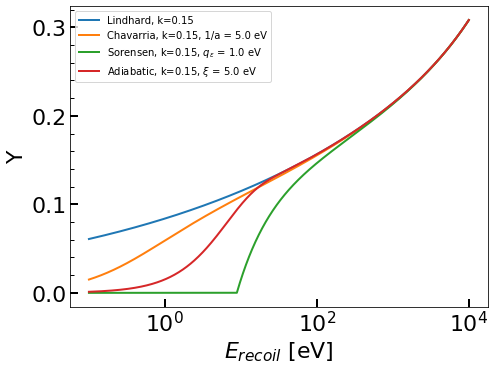

In [3]:
fig,ax = plt.subplots(1,1,figsize=(fig_w, fig_w*(.75)))

#Y=Yield.Yield('Damic',[])
#plt.plot(E_test,Y.calc(E_test),label='Damic')

k=0.15

Y=Yield.Yield('Lind',[k])
plt.plot(E_test,Y.calc(E_test),label='Lindhard, k={0:.2f}'.format(k))

#Y=Yield.Yield('Chav',[0.146,4e3])

ainv=5 #[eV]
Y=Yield.Yield('Chav',[0.15,ainv])
plt.plot(E_test,Y.calc(E_test),label='Chavarria, k={0:.2f}, 1/a = {1:.1f} eV'.format(k,ainv))

qeff_eV=1 #[eV]
Y=Yield.Yield('Sor',[0.15,qeff_eV*eVTOeps])
plt.plot(E_test,Y.calc(E_test),label='Sorensen, k={0:.2f}, $q_\epsilon$ = {1:.1f} eV'.format(k,qeff_eV))

xi=5 #[eV]
Y=Yield.Yield('AC',[0.15,xi])
plt.plot(E_test,Y.calc(E_test),label=r'Adiabatic, k={0:.2f}, $\xi$ = {1:.1f} eV'.format(k,xi))

ax.set_xlabel(r'$E_{recoil}$ [eV]')
ax.set_ylabel('Y')
ax.set_xscale('log')
#ax.set_xlim(0,10)
#ax.set_xlim(1e2,1e5)

#ax.set_yscale('log')
#ax.set_ylim(1e-1,0.5)


#pt.plotOldYs(plt.gca())

#plt.legend(loc="upper left")
plt.legend()
plt.tight_layout()
plt.savefig('figures/yield_models.png')

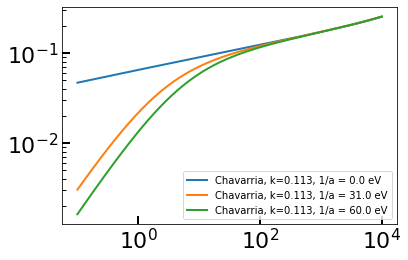

In [4]:
Y=Yield.Yield('Chav',[0.113,0])
plt.plot(E_test,Y.calc(E_test),label='Chavarria, k=0.113, 1/a = {0:.1f} eV'.format(round(0)))

Y=Yield.Yield('Chav',[0.114,31])
plt.plot(E_test,Y.calc(E_test),label='Chavarria, k=0.113, 1/a = {0:.1f} eV'.format(round(31)))
Y=Yield.Yield('Chav',[0.114,60])
plt.plot(E_test,Y.calc(E_test),label='Chavarria, k=0.113, 1/a = {0:.1f} eV'.format(round(60)))


plt.gca().set_xscale('log')
plt.gca().set_yscale('log')

plt.legend()

In [5]:
Y=Yield.Yield('AC',[0.15,xi])

In [12]:
Y.set_model('Lind')
Y.set_pars([4,2])
Y.npars

Error: Lind yield model takes 1 parameters, but 2 are given.


1